In [4]:
import pandas as pd
import json
import re
import tifffile as tiff
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image
from tqdm import tqdm

from sklearn.linear_model import LinearRegression

In [2]:
with tiff.TiffFile('4-2.tif') as tif:
    frames = tif.asarray()

### Background init

> model of the background

In [5]:
def initialBackgroundv2(frame: np.array)->np.array:
    """ 
    Performs background subtraction

    Args:
    -----
    - `frame`: the one frame we want to create the background from

    Output:
    -------
    The background of the image
    """
    
    L = frame.shape[0] // 2
    
    ## detect big lines and zone above or below (will simply set them as the background
    # --> big assumption here)

    test = np.sum(frame, axis = 1)
    thresh = np.min(test) * 6               # some arbritrary threshold
    ids = np.where(test < thresh)[0]        # y ids of the lines

    idMin = ids[ids < L]
    idMax = ids[ids > L]
    maxIdMin = np.max(idMin)
    minIdMax = np.min(idMax)

    idMin = np.arange(maxIdMin+1)
    idMax = np.arange(minIdMax, frame.shape[0])

    ## tackle the middle part
    ## model the horizontal color shift
    ## delete those values in the computation from the initial frame
    linearIdsList = np.random.randint(0, frame.shape[0], 5)     # 5 lines for linear model, (5 is arbritrary) ...

    y = None

    for i in range(len(linearIdsList)):
        if linearIdsList[i] in idMin or linearIdsList[i] in idMax:
            if linearIdsList[i] < L:
                linearIdsList[i] += np.random.randint(40, L)    #just to get it off the zone
            else:
                linearIdsList[i] -= np.random.randint(40, L)    # just to get it off the zone
        
        if y is None:
            y = frame[i, :].reshape(1, -1)
        else:
            y = np.vstack((y, frame[i, :]))

    X = np.tile(np.arange(frame.shape[1])[np.newaxis, :], (len(linearIdsList), 1))


    model = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))
    preds = model.predict(np.arange(frame.shape[1]).reshape(-1,1)).reshape(1,-1)
    bg = np.tile(preds, (frame.shape[0], 1))
    
    # replace the two other zone
    bg[idMin, :] = frame[idMin, :]
    bg[idMax, :] = frame[idMax, :]
    bg = bg.astype(int)

    return bg


### Background update

### Generic class for everything

In [14]:
class background_sub():
    def __init__(self, frames, params):
        self.frames = frames

        self.alpha = params[0]          # exponential filter

        self.threshold = params[1]      # threshold comparison

        self.initFrameId = 0           # id of the first frame

        self.binMaps = []               # list of binary maps
        
    def _initBg(self, frames):
        
        bg = initialBackgroundv2(frames[0][:,:, 0])
        #bg = initialBackgroundv2(frames[0])        

        return bg

    def _updateBg(self, prevBg, frame, alpha, bMap):
        # exponential filter

        # whole frame update
        return (alpha * prevBg + (1-alpha) * frame)

        #only background updated

        #invMap = ~bMap
        #bg2 = alpha * prevBg[invMap] + (1-alpha) * frame[invMap]

        #return bg2
    
    def _compareFrames(self, frame, bg, threshold):
        # compare frames

        d = np.abs(bg - frame)

        plt.imshow(d)
        plt.colorbar()
        plt.show()

        bMap = (d >= threshold)
        return bMap


    def _loop(self):

        bg = self._initBg(self.frames)

        for i in tqdm(range(self.initFrameId, len(self.frames))):
            bMap = self._compareFrames(self.frames[i][:, :, 0], bg, self.threshold)
            #bMap = self._compareFrames(self.frames[i], bg, self.threshold)
            
            self.binMaps.append(bMap)

            #bg = self._updateBg(bg, self.frames[i], self.alpha)
            bg = self._updateBg(bg, self.frames[i][:, :, 0], self.alpha, bMap)

            bg = bg.astype(int)
        return self.binMaps
    


  0%|          | 0/5 [00:00<?, ?it/s]

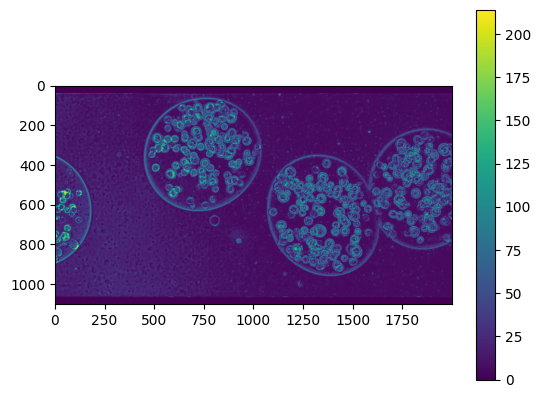

 20%|██        | 1/5 [00:00<00:01,  2.16it/s]


ValueError: operands could not be broadcast together with shapes (1870884,) (1100,2000) 

In [15]:
bgS = background_sub(frames[:5], [0.95, 40])

bMap = bgS._loop()

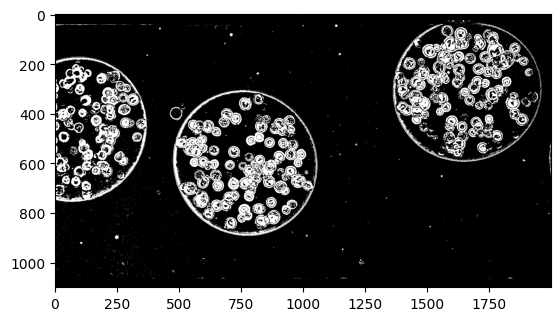

In [12]:
plt.imshow(bMap[3], cmap='gray')        # basis 

In [13]:
print(bMap[3])

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
